In [57]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import acf

def analyze_periodicity(path, name):
    # Load data
    df = pd.read_csv(path, parse_dates=['timestamp'], index_col='timestamp')
    Cp = 4182
    # Compute heat load Q in kJ
    df['Q'] = df['m'] * Cp * (df['Ts'] - df['Tr']) / 3600
    # Resample to 15-minute intervals
    df = df[['Q']].resample('15T').mean().ffill()

    # 1. Autocorrelation
    acf_vals = acf(df['Q'], nlags=168, fft=True)
    acf_daily   = acf_vals[24]
    acf_weekly  = acf_vals[168]


    # Compile results
    results = {
        'Dataset': name,
        'ACF@24h': acf_daily,
        'ACF@168h': acf_weekly,
    }
    return results

# Paths to CSV files
paths = {
    'Public-Commercial': '/Users/aniaboutarene/Desktop/heat_load_data_pubcom.csv',
    'Office': '/Users/aniaboutarene/Desktop/heat_load_data_office.csv',
    'Hotel': '/Users/aniaboutarene/Desktop/heat_load_data_hotel.csv'
}

# Analyze and output results
results_list = []
for name, path in paths.items():
    try:
        res = analyze_periodicity(path, name)
        results_list.append(res)
    except FileNotFoundError:
        print(f"File not found: {path}. Please adjust the path.")

if results_list:
    results_df = pd.DataFrame(results_list).set_index('Dataset')
    # Print summary table
    print("Periodicity Metrics:\n", results_df)

Periodicity Metrics:
                     ACF@24h  ACF@168h
Dataset                              
Public-Commercial  0.941009  0.807343
Office             0.394518  0.272421
Hotel              0.721336  0.566469


In [15]:
from statsmodels.stats.diagnostic import acorr_ljungbox, het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
import statsmodels.api as sm
from scipy.stats import shapiro, anderson, kstest
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import holidays
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Conv1D, MaxPooling1D, UpSampling1D, Flatten, Reshape,
                                     LSTM, Dropout, RepeatVector, TimeDistributed, Dense, 
                                     Input, Cropping1D, ZeroPadding1D, Conv2D, MaxPooling2D, 
                                     UpSampling2D, Cropping2D, ZeroPadding2D)
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt
import math
import warnings
# Ignore all UserWarning messages site-wide
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
# =============================================================================
# 0. Define a Custom Layer: RandomGaussianNoise
# =============================================================================
class RandomGaussianNoise(tf.keras.layers.Layer):
    def __init__(self, min_std=0.0, max_std=0.15, **kwargs):
        super(RandomGaussianNoise, self).__init__(**kwargs)
        self.min_std = min_std
        self.max_std = max_std

    def call(self, inputs, training=None):
        if training:
            noise_std = tf.random.uniform([], minval=self.min_std, maxval=self.max_std)
            noise = tf.random.normal(tf.shape(inputs)) * noise_std
            return inputs + noise
        return inputs

# =============================================================================
# 1. Load and Basic Preprocessing of Heat-Load Data
# =============================================================================
df = pd.read_csv("/Users/aniaboutarene/Desktop/heat_load_data_pubcom.csv")  # Adjust path as needed
Cp = 4182
df['Q'] = df['m'] * Cp * (df["Ts"] - df["Tr"]) / 3600

# Retain only timestamp and Q
df = df[['timestamp', 'Q']]
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)

# Resample to 15 minutes and fill missing values
df = df.resample('15T').mean()
df['Q'] = df['Q'].ffill()

# =============================================================================
# 2. Feature Engineering (Time-based Features Only)
# =============================================================================
df["hour"] = df.index.hour
df["dayofweek"] = df.index.dayofweek
df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)
df["dow_sin"]  = np.sin(2 * np.pi * df["dayofweek"] / 7)
df["dow_cos"]  = np.cos(2 * np.pi * df["dayofweek"] / 7)
df['weekend'] = df.index.dayofweek.isin([5,6]).astype(int)
austrian_holidays = holidays.Austria(years=df.index.year.unique())
df['holiday'] = df.index.isin(austrian_holidays).astype(int)

# =============================================================================
# 3. Select Features & Split Data by Date
# =============================================================================
features = df[["Q", "hour_sin", "hour_cos", "dow_sin", "dow_cos", "weekend", "holiday"]]

# Split the dataset on the date "2024-04-02"
test_df = features.loc[features.index >= '2024-04-02'].copy()
train_df = features.loc[features.index < '2024-04-02'].copy()

# =============================================================================
# 4. Further Split train_df into train_df and val_df
# =============================================================================
val_size = int(len(train_df) * 0.1)
val_df = train_df.iloc[-val_size:].copy()
train_df = train_df.iloc[:-val_size].copy()

# =============================================================================
# 5. Scaling and Sequence Creation
# =============================================================================
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_df)
val_scaled   = scaler.transform(val_df)
test_scaled  = scaler.transform(test_df)

def create_sequences(data, lookback, horizon, target_col=0):
    X, y = [], []
    for i in range(len(data) - lookback - horizon + 1):
        X_seq = data[i : i + lookback]
        y_seq = data[i + lookback : i + lookback + horizon, target_col]
        X.append(X_seq)
        y.append(y_seq)
    return np.array(X), np.array(y).reshape(-1, horizon, 1)

lookback = 8   # 2 hours lookback (8 time steps of 15 minutes each)
horizon  = 1   # Forecasting 15 minutes ahead

X_train, y_train = create_sequences(train_scaled, lookback, horizon)
X_val, y_val     = create_sequences(val_scaled, lookback, horizon)
X_test, y_test   = create_sequences(test_scaled, lookback, horizon)

# Since our modified model treats each sample as an image, add a channel dimension:
X_train = X_train[..., np.newaxis]   # now shape: (samples, lookback, num_features, 1)
X_val   = X_val[..., np.newaxis]
X_test  = X_test[..., np.newaxis]

# =============================================================================
# 6. Define Model Building Functions (Parameterizing num_features)
# =============================================================================
def build_baseline_model(hp, num_features):
    lstm_units = hp.Choice('lstm_units', values=[32, 64, 128], default=64)
    dropout_rate = hp.Choice('dropout_rate', values=[0.1, 0.2, 0.3], default=0.2)
    model = Sequential([
        LSTM(lstm_units, input_shape=(lookback, num_features), return_sequences=False),
        Dense(32, activation='linear'),
        Dropout(dropout_rate),
        RepeatVector(horizon),
        LSTM(64, return_sequences=True),
        TimeDistributed(Dense(1))
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mae', metrics=['mae'])
    return model

def build_dae_model(hp, num_features):
    inputs = Input(shape=(lookback, num_features))
    x = RandomGaussianNoise(min_std=0.0, max_std=0.15)(inputs)
    x = TimeDistributed(Dense(64, activation='elu'))(x)
    x = TimeDistributed(Dense(32, activation='elu'))(x)
    latent = LSTM(32, activation='tanh', return_sequences=False, name="latent_space")(x)
    x_dec = RepeatVector(lookback)(latent)
    x_dec = LSTM(64, activation='tanh', return_sequences=True)(x_dec)
    x_dec = TimeDistributed(Dense(32, activation='elu'))(x_dec)
    x_dec = TimeDistributed(Dense(64, activation='elu'))(x_dec)
    outputs = TimeDistributed(Dense(num_features, activation='linear'))(x_dec)
    dae = Model(inputs, outputs)
    dae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')
    
    # Build forecasting branch
    dae_encoder = Model(inputs, dae.get_layer("latent_space").output)
    forecast_dropout = hp.Choice('forecast_dropout', values=[0.1, 0.2, 0.3], default=0.2)
    latent_input = Input(shape=(32,))
    x_f = Dropout(forecast_dropout)(latent_input)
    x_f = RepeatVector(horizon)(x_f)
    x_f = LSTM(64, return_sequences=True)(x_f)
    forecast_output = TimeDistributed(Dense(1))(x_f)
    forecast_model = Model(latent_input, forecast_output)
    forecast_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mae', metrics=['mae'])
    
    outputs_forecast = forecast_model(dae_encoder(inputs))
    combined_model = Model(inputs, outputs_forecast)
    combined_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mae', metrics=['mae'])
    return combined_model

def build_conv_dae_model(hp, num_features):
    # Modified version: treat the data as an image
    # New input shape: (lookback, num_features, 1)
    inputs = Input(shape=(lookback, num_features, 1))
    x = RandomGaussianNoise(min_std=0.0, max_std=0.15)(inputs)
    
    # Encoder: use 2D Conv layers with a 3x3 kernel and ELU activation, followed by MaxPooling2D
    x = Conv2D(filters=5, kernel_size=(3, 3), strides=(1, 1), activation='elu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
    x = Conv2D(filters=25, kernel_size=(3, 3), strides=(1, 1), activation='elu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
    x = Conv2D(filters=125, kernel_size=(3, 3), strides=(1, 1), activation='elu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
    
    # Flatten the feature maps and build the latent representation
    x = Flatten()(x)
    latent = Dense(32, activation='linear', name='latent_space')(x)
    
    # Decoder: reverse encoder steps
    # Determine dimensions after three poolings (each pool reduces dimension by factor of 2)
    encoded_height = int(math.ceil(lookback / 2 / 2 / 2))
    encoded_width  = int(math.ceil(num_features / 2 / 2 / 2))
    flattened_dim = encoded_height * encoded_width * 125
    x_dec = Dense(flattened_dim, activation='elu')(latent)
    x_dec = Reshape((encoded_height, encoded_width, 125))(x_dec)
    
    x_dec = UpSampling2D(size=(2, 2))(x_dec)
    x_dec = Conv2D(filters=25, kernel_size=(3, 3), strides=(1, 1), activation='elu', padding='same')(x_dec)
    x_dec = UpSampling2D(size=(2, 2))(x_dec)
    x_dec = Conv2D(filters=5, kernel_size=(3, 3), strides=(1, 1), activation='elu', padding='same')(x_dec)
    x_dec = UpSampling2D(size=(2, 2))(x_dec)
    
    # Adjust output dimensions to match original (lookback, num_features)
    current_height = encoded_height * 2 * 2 * 2  # After three upsampling layers
    current_width  = encoded_width * 2 * 2 * 2
    if current_height > lookback or current_width > num_features:
        crop_height = current_height - lookback
        crop_width = current_width - num_features
        x_dec = Cropping2D(cropping=((0, crop_height), (0, crop_width)))(x_dec)
    elif current_height < lookback or current_width < num_features:
        pad_height = lookback - current_height
        pad_width = num_features - current_width
        x_dec = ZeroPadding2D(padding=((0, pad_height), (0, pad_width)))(x_dec)
    
    # Final reconstruction: output channels should be 1
    outputs_recon = Conv2D(filters=1, kernel_size=(3, 3), strides=(1, 1), activation='linear', padding='same')(x_dec)
    conv_autoencoder = Model(inputs, outputs_recon)
    conv_autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')
    
    # Forecasting branch
    conv_encoder = Model(inputs, conv_autoencoder.get_layer("latent_space").output)
    conv_forecast_dropout = hp.Choice('conv_forecast_dropout', values=[0.1, 0.2, 0.3], default=0.2)
    latent_input = Input(shape=(32,))
    x_f = Dropout(conv_forecast_dropout)(latent_input)
    x_f = RepeatVector(horizon)(x_f)
    x_f = LSTM(64, return_sequences=True)(x_f)
    forecast_output = TimeDistributed(Dense(1))(x_f)
    forecast_model = Model(latent_input, forecast_output)
    forecast_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mae', metrics=['mae'])
    
    outputs_forecast = forecast_model(conv_encoder(inputs))
    combined_model = Model(inputs, outputs_forecast)
    combined_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mae', metrics=['mae'])
    return combined_model

# =============================================================================
# 7. Hyperparameter Tuning for Each Model using Keras Tuner (5 Trials Each)
# =============================================================================
num_features = X_train.shape[2]  # Note: X_train is now 4D, but num_features remains unchanged

# Baseline LSTM (No Weather)
tuner_baseline = kt.RandomSearch(
    lambda hp: build_baseline_model(hp, num_features),
    objective='val_loss',
    max_trials=5,
    executions_per_trial=1,
    directory='tuning_dir_pubcom_2g1_leak_new_o',
    project_name='baseline_model_no_weather'
)
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

print("Tuning Baseline LSTM ")
tuner_baseline.search(X_train[..., 0], y_train, epochs=100, validation_data=(X_val[..., 0], y_val),
    callbacks=[early_stop])
best_baseline_model = tuner_baseline.get_best_models(num_models=1)[0]

# DAE+LSTM (No Weather)
tuner_dae = kt.RandomSearch(
    lambda hp: build_dae_model(hp, num_features),
    objective='val_loss',
    max_trials=5,
    executions_per_trial=1,
    directory='tuning_dir_pubcom_2g1_leak_new_o',
    project_name='dae_model_no_weather'
)
print("Tuning DAE+LSTM ")
tuner_dae.search(X_train[..., 0], y_train, epochs=100, validation_data=(X_val[..., 0], y_val),
    callbacks=[early_stop])
best_dae_model = tuner_dae.get_best_models(num_models=1)[0]

# CDAE+LSTM (No Weather)
tuner_conv_dae = kt.RandomSearch(
    lambda hp: build_conv_dae_model(hp, num_features),
    objective='val_loss',
    max_trials=5,
    executions_per_trial=1,
    directory='tuning_dir_pubcom_2g1_leak_new_o',
    project_name='conv_dae_model_no_weather'
)
print("Tuning CDAE+LSTM ")
tuner_conv_dae.search(X_train, y_train, epochs=100, validation_data=(X_val, y_val),callbacks=[early_stop])
best_conv_dae_model = tuner_conv_dae.get_best_models(num_models=1)[0]
# =============================================================================
# 8. Evaluate Models 
# =============================================================================

# Define helper functions

def add_noise(data, noise_std=0.1):
    return data + np.random.normal(0, noise_std, data.shape)


def safe_inverse_transform(pred_scaled, scaler):
    dummy = np.zeros((pred_scaled.shape[0], scaler.min_.shape[0]))
    dummy[:, 0] = pred_scaled
    inv = scaler.inverse_transform(dummy)
    return inv[:, 0]


def mape(y_true, y_pred, eps=1e-8):
    return np.mean(np.abs((y_true - y_pred) / (y_true + eps))) * 100


def mae_fn(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

# Retrieve true Q values
true_Q_test = safe_inverse_transform(y_test.reshape(-1), scaler)

# Prepare storage for summary metrics
results = []  # list of dicts: noise, model, mape, mae, lb_stat, lb_p, arch_stat, arch_p, ad_stat, ad_crit

noise_levels = [0.05, 0.1, 0.15]
models = [
    ('Baseline LSTM',    best_baseline_model, lambda X: X[...,0]),
    ('DAE+LSTM',         best_dae_model,       lambda X: X[...,0]),
    ('CDAE+LSTM',        best_conv_dae_model,  lambda X: X)
]

for noise_std in noise_levels:
    Xn = add_noise(X_test, noise_std)
    for name, model, slicer in models:
        # Predictions and inverse transform
        X_input = slicer(Xn)
        preds = model.predict(X_input).reshape(-1)
        preds_inv = safe_inverse_transform(preds, scaler)
        resid = true_Q_test - preds_inv

        # Compute metrics
        current_mape = mape(true_Q_test, preds_inv)
        current_mae  = mae_fn(true_Q_test, preds_inv)

        # Autocorrelation test
        lb = acorr_ljungbox(resid, lags=[10], return_df=True)
        lb_stat, lb_p = lb.lb_stat.iloc[0], lb.lb_pvalue.iloc[0]

        # ARCH test
        arch_stat, arch_pvalue, _, _ = sm.stats.diagnostic.het_arch(resid)

        # Anderson-Darling
        ad = anderson(resid, dist='norm')
        ad_stat = ad.statistic
        ad_crit = dict(zip(ad.significance_level, ad.critical_values))

        # Store results
        results.append({
            'noise_pct': noise_std * 100,
            'model': name,
            'MAPE': current_mape,
            'MAE': current_mae,
            'LjungBox_chi2': lb_stat,
            'LjungBox_p': lb_p,
            'ARCH_LM': arch_stat,
            'ARCH_p': arch_pvalue,
            'AD_stat': ad_stat,
            'AD_crit_vals': ad_crit
        })

# Display summary
for res in results:
    print(f"Noise {res['noise_pct']:.0f}% - Model: {res['model']}")
    print(f" MAPE: {res['MAPE']:.2f}%, MAE: {res['MAE']:.2f}")
    print(f" Ljung-Box: chi2={res['LjungBox_chi2']:.2f}, p={res['LjungBox_p']:.3f}")
    print(f" ARCH: LM={res['ARCH_LM']:.2f}, p={res['ARCH_p']:.3f}")
    crit_str = ', '.join(f"{sl}%:{cv:.2f}" for sl, cv in res['AD_crit_vals'].items())
    print(f" Anderson-Darling: A2={res['AD_stat']:.3f}, crit={{{crit_str}}}\n")


Reloading Tuner from tuning_dir_pubcom_2g1_leak_new_o/baseline_model_no_weather/tuner0.json
Tuning Baseline LSTM 
Reloading Tuner from tuning_dir_pubcom_2g1_leak_new_o/dae_model_no_weather/tuner0.json
Tuning DAE+LSTM 
Reloading Tuner from tuning_dir_pubcom_2g1_leak_new_o/conv_dae_model_no_weather/tuner0.json
Tuning CDAE+LSTM 
822/822 ━━━━━━━━━━━━━━━━━━━━ 1s 618us/step
822/822 ━━━━━━━━━━━━━━━━━━━━ 1s 738us/step
822/822 ━━━━━━━━━━━━━━━━━━━━ 1s 723us/step
822/822 ━━━━━━━━━━━━━━━━━━━━ 1s 705us/step
822/822 ━━━━━━━━━━━━━━━━━━━━ 1s 743us/step
822/822 ━━━━━━━━━━━━━━━━━━━━ 1s 714us/step
822/822 ━━━━━━━━━━━━━━━━━━━━ 1s 684us/step
822/822 ━━━━━━━━━━━━━━━━━━━━ 1s 736us/step
822/822 ━━━━━━━━━━━━━━━━━━━━ 1s 682us/step
Noise 5% - Model: Baseline LSTM
 MAPE: 2.64%, MAE: 120.02
 Ljung-Box: chi2=101.64, p=0.000
 ARCH: LM=1056.91, p=0.000
 Anderson-Darling: A2=9.991, crit={15.0%:0.58, 10.0%:0.66, 5.0%:0.79, 2.5%:0.92, 1.0%:1.09}

Noise 5% - Model: DAE+LSTM
 MAPE: 2.16%, MAE: 96.83
 Ljung-Box: chi2=21335

Reloading Tuner from tuning_dir_office_2g1_leak_new_o/baseline_model_no_weather/tuner0.json
Tuning Baseline LSTM (No Weather)...
Reloading Tuner from tuning_dir_office_2g1_leak_new/dae_model_no_weather/tuner0.json
Tuning DAE+LSTM (No Weather)...
Reloading Tuner from tuning_dir_office_2g1_leak_new_2D/conv_dae_model_no_weather/tuner0.json
Tuning CDAE+LSTM (No Weather)...
822/822 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
822/822 ━━━━━━━━━━━━━━━━━━━━ 1s 702us/step
822/822 ━━━━━━━━━━━━━━━━━━━━ 1s 672us/step
822/822 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
822/822 ━━━━━━━━━━━━━━━━━━━━ 1s 719us/step
822/822 ━━━━━━━━━━━━━━━━━━━━ 1s 683us/step
822/822 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
822/822 ━━━━━━━━━━━━━━━━━━━━ 1s 735us/step
822/822 ━━━━━━━━━━━━━━━━━━━━ 1s 677us/step
Noise 5% - Model: Baseline LSTM
 MAPE: 9.27%, MAE: 334.22
 Ljung-Box: chi2=202.22, p=0.000
 ARCH: LM=1442.16, p=0.000
 Anderson-Darling: A2=825.567, crit={15.0%:0.58, 10.0%:0.66, 5.0%:0.79, 2.5%:0.92, 1.0%:1.09}

Noise 5% - Model: DAE+LSTM
 MAPE: 

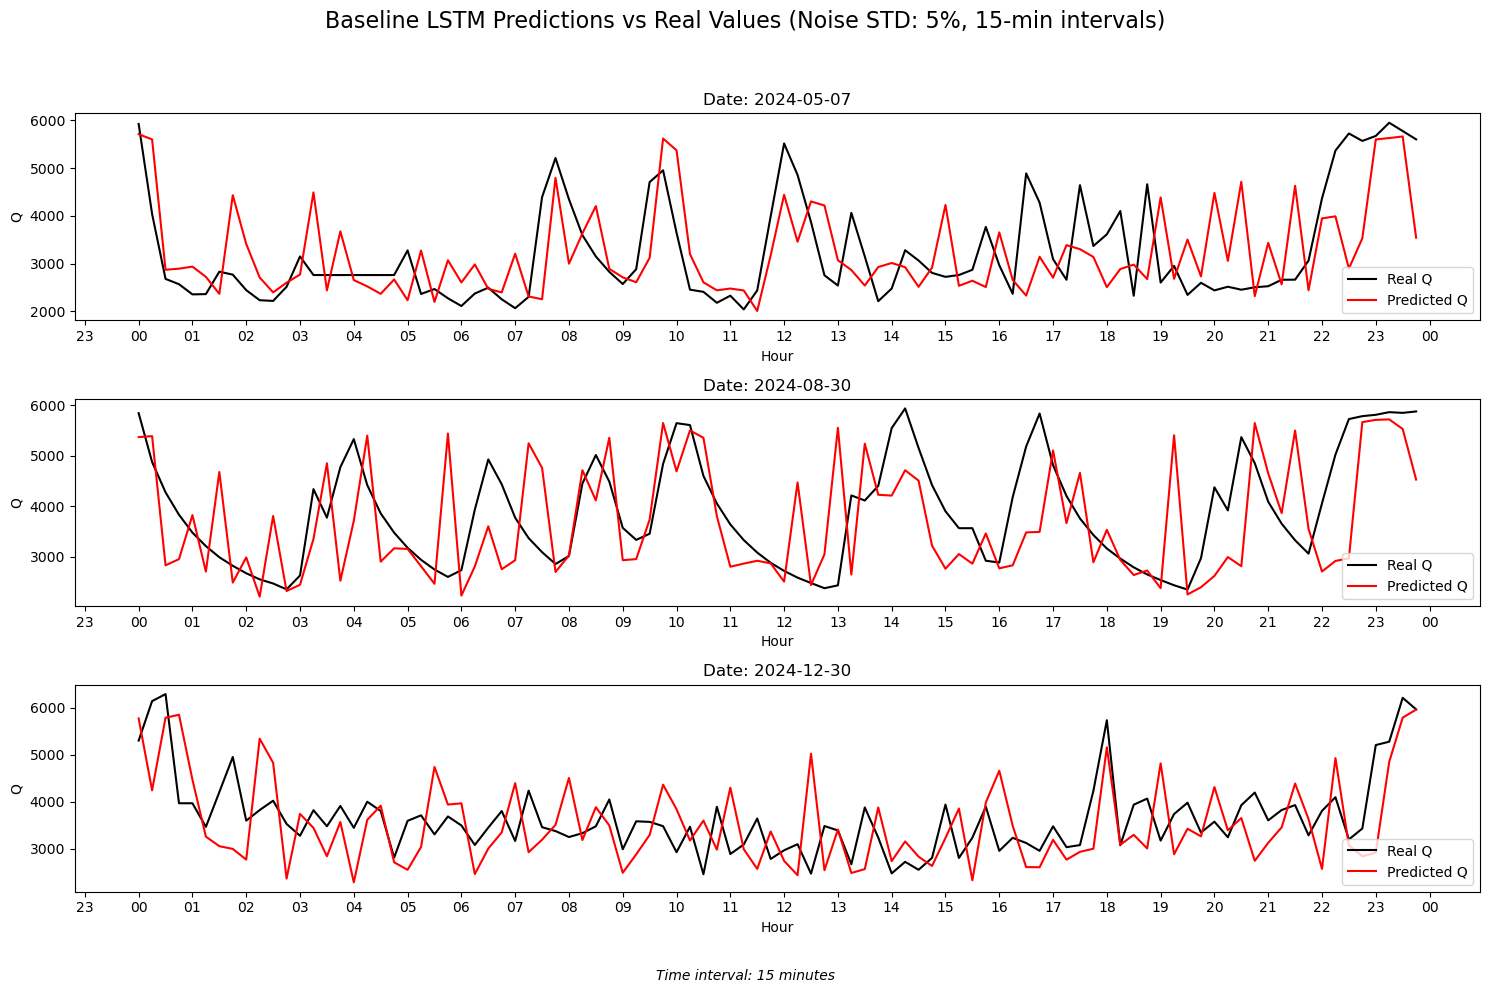

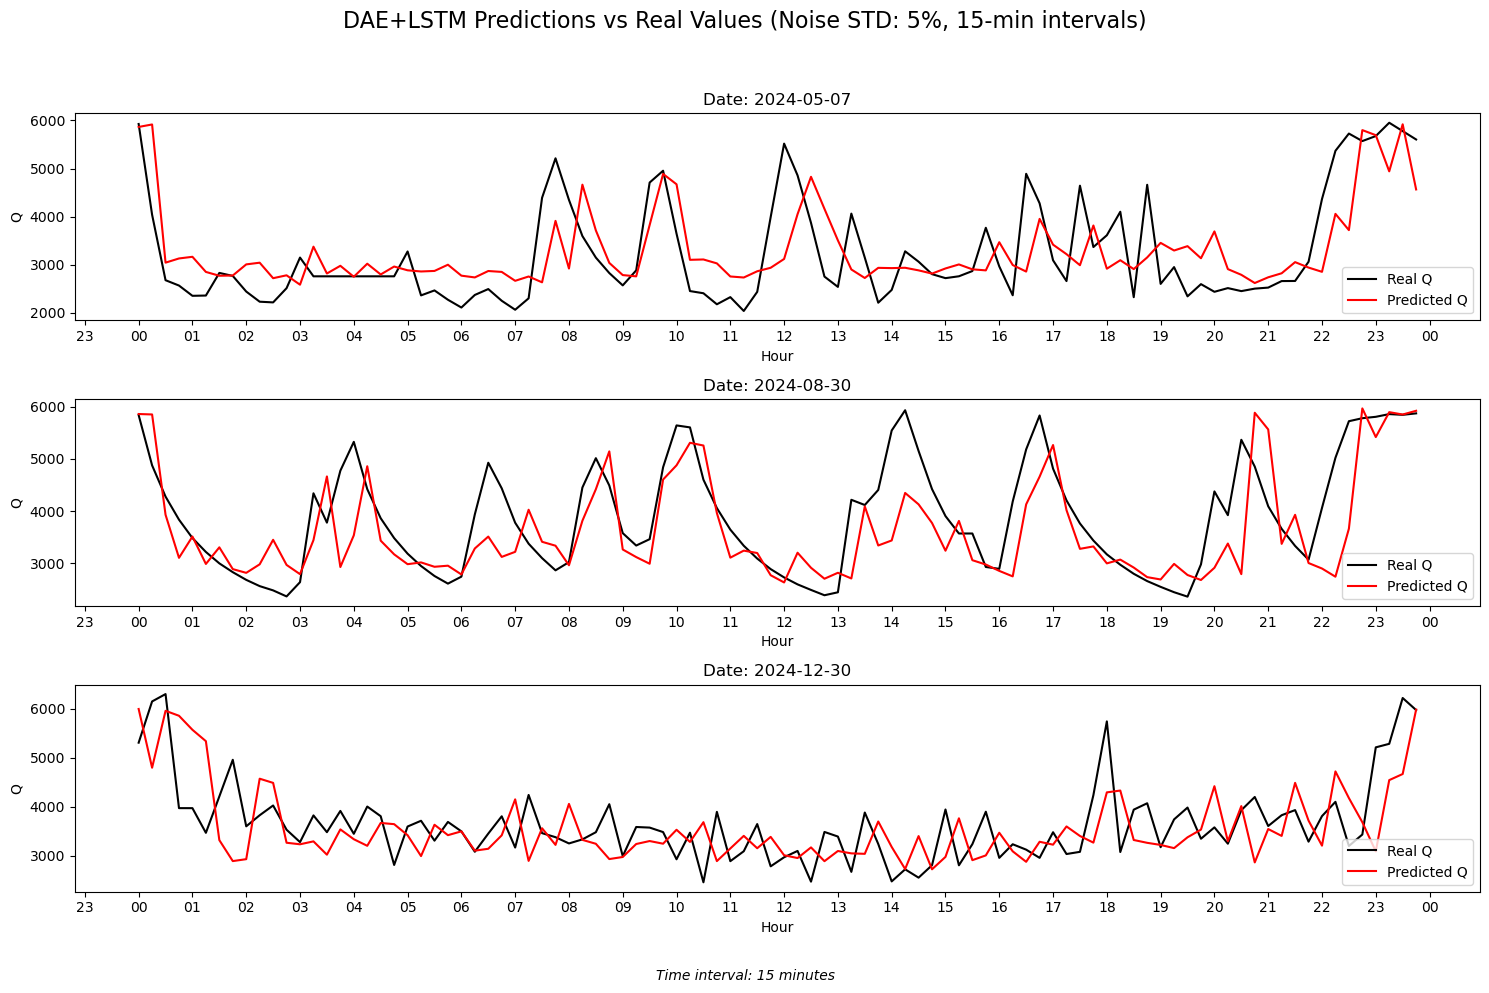

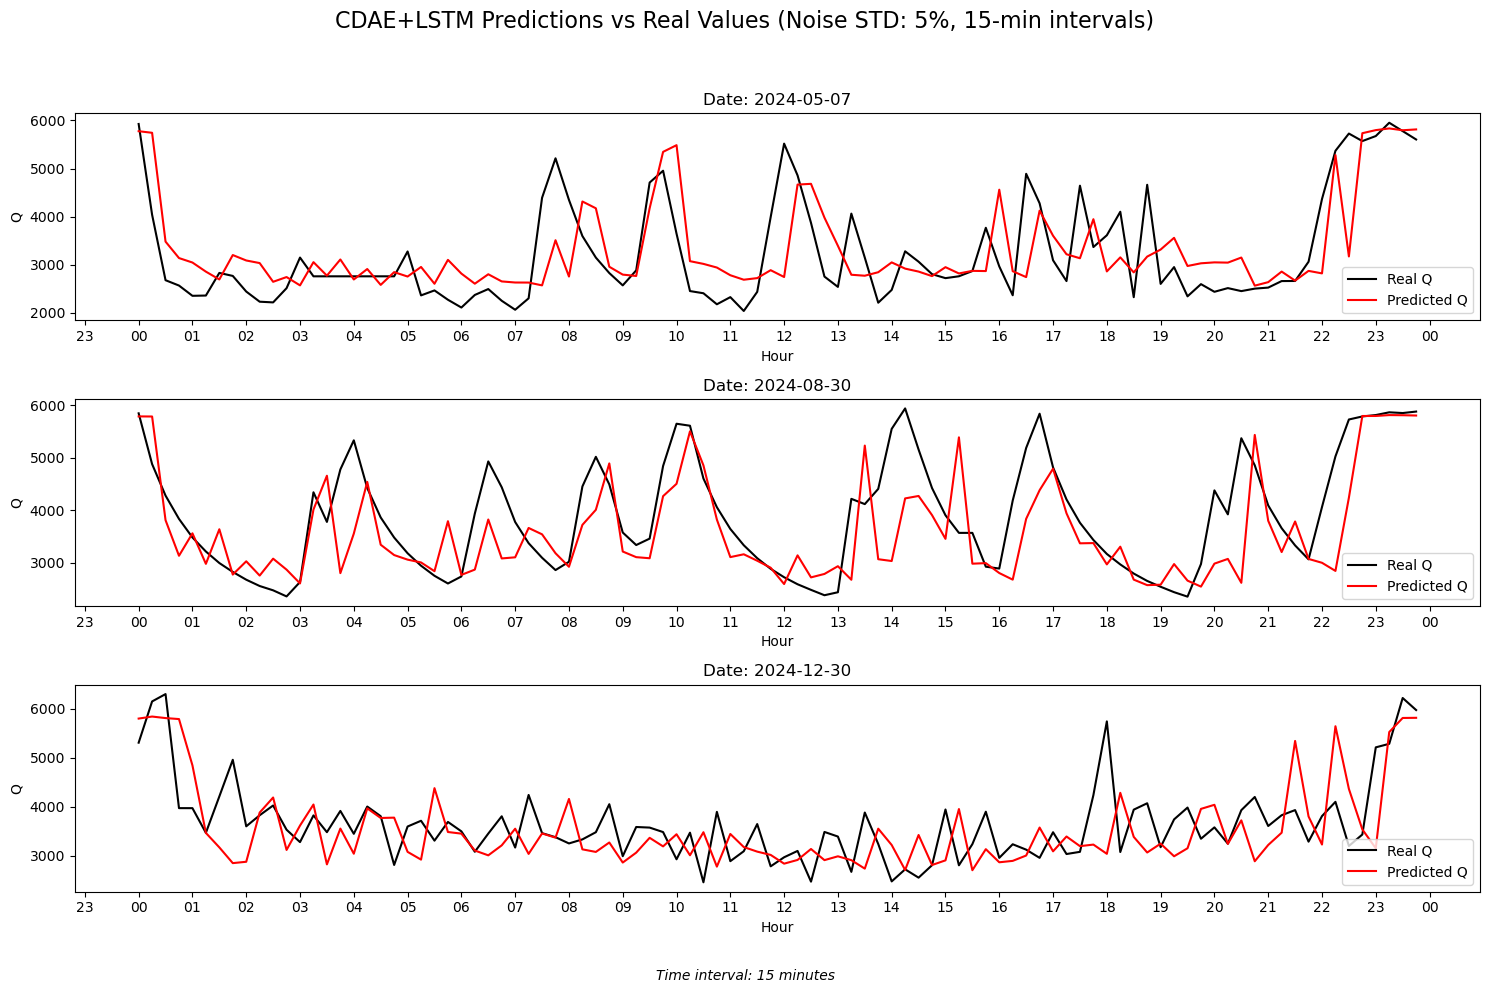

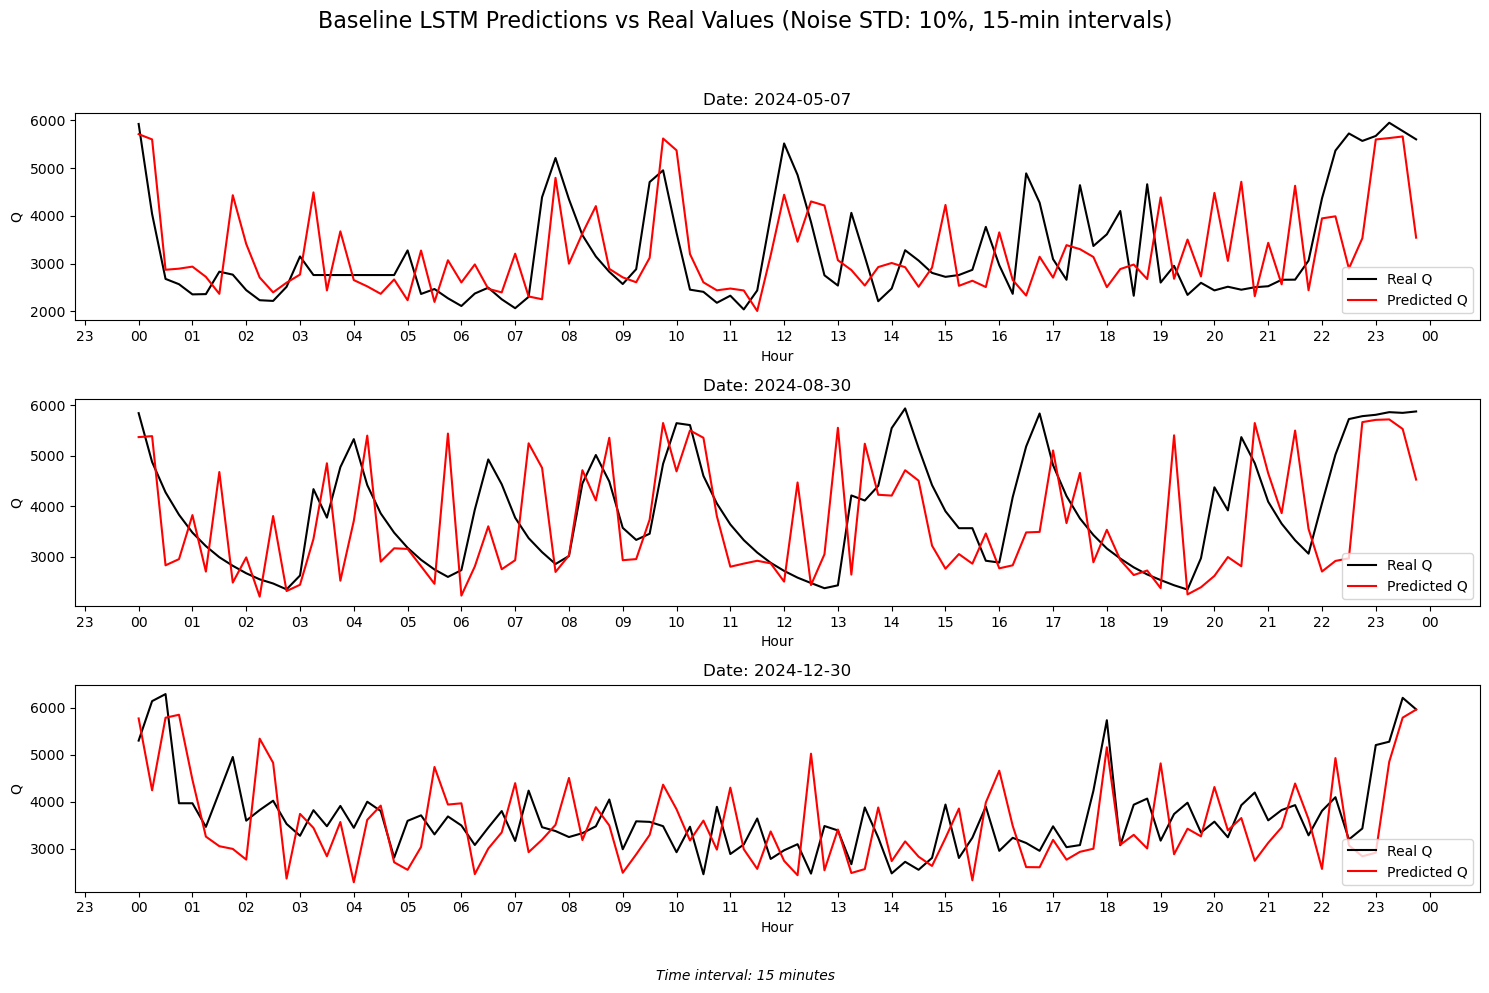

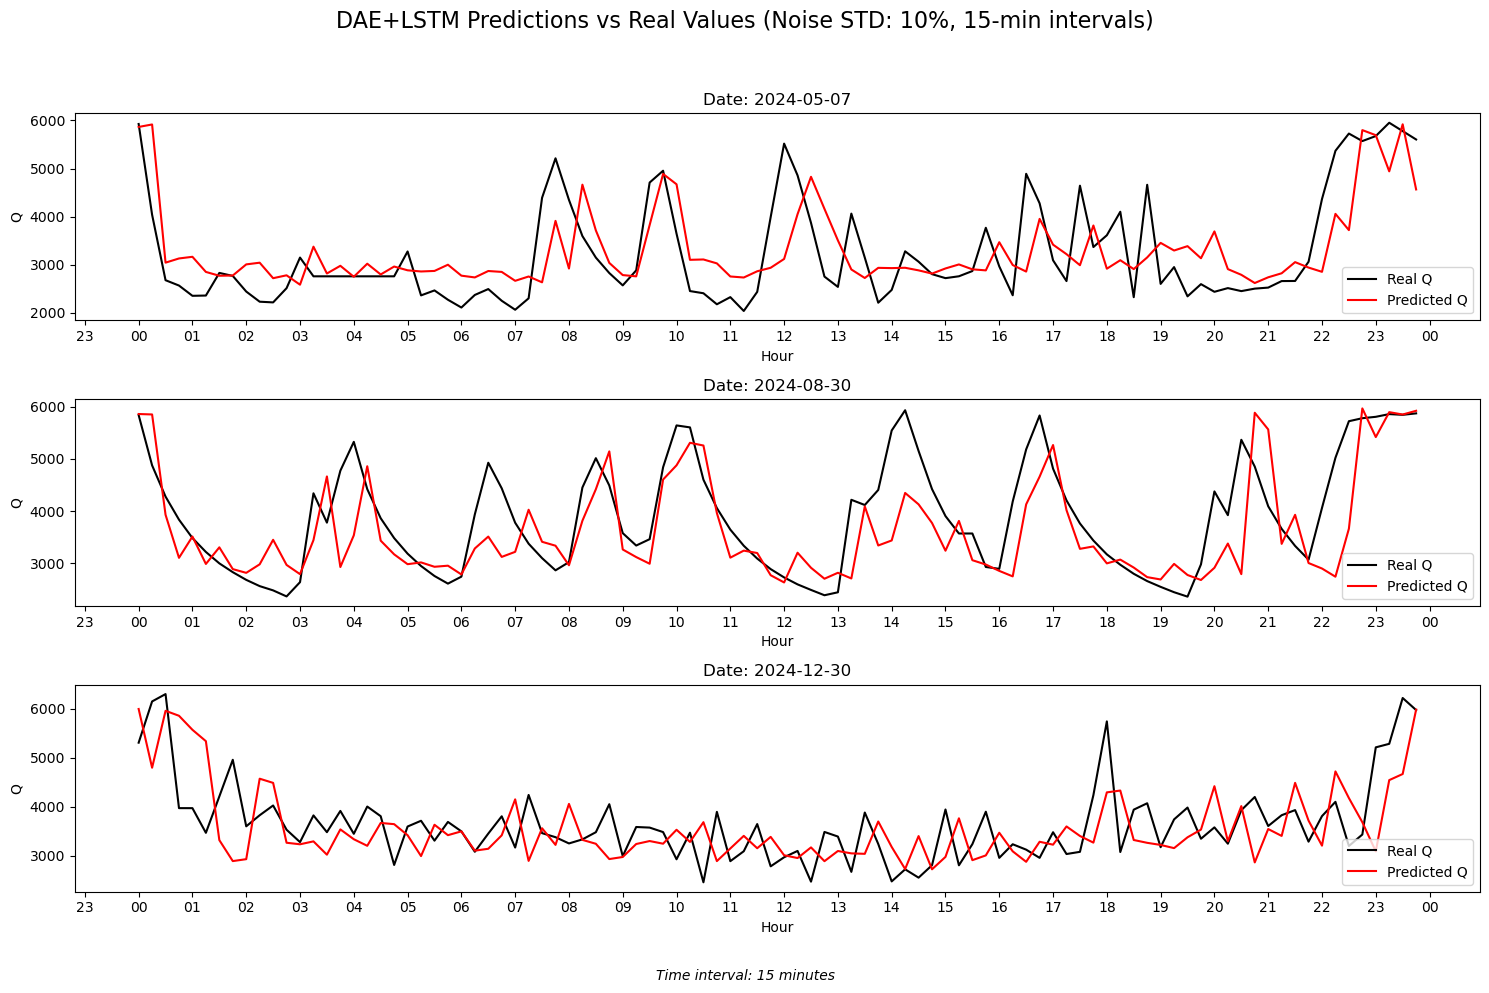

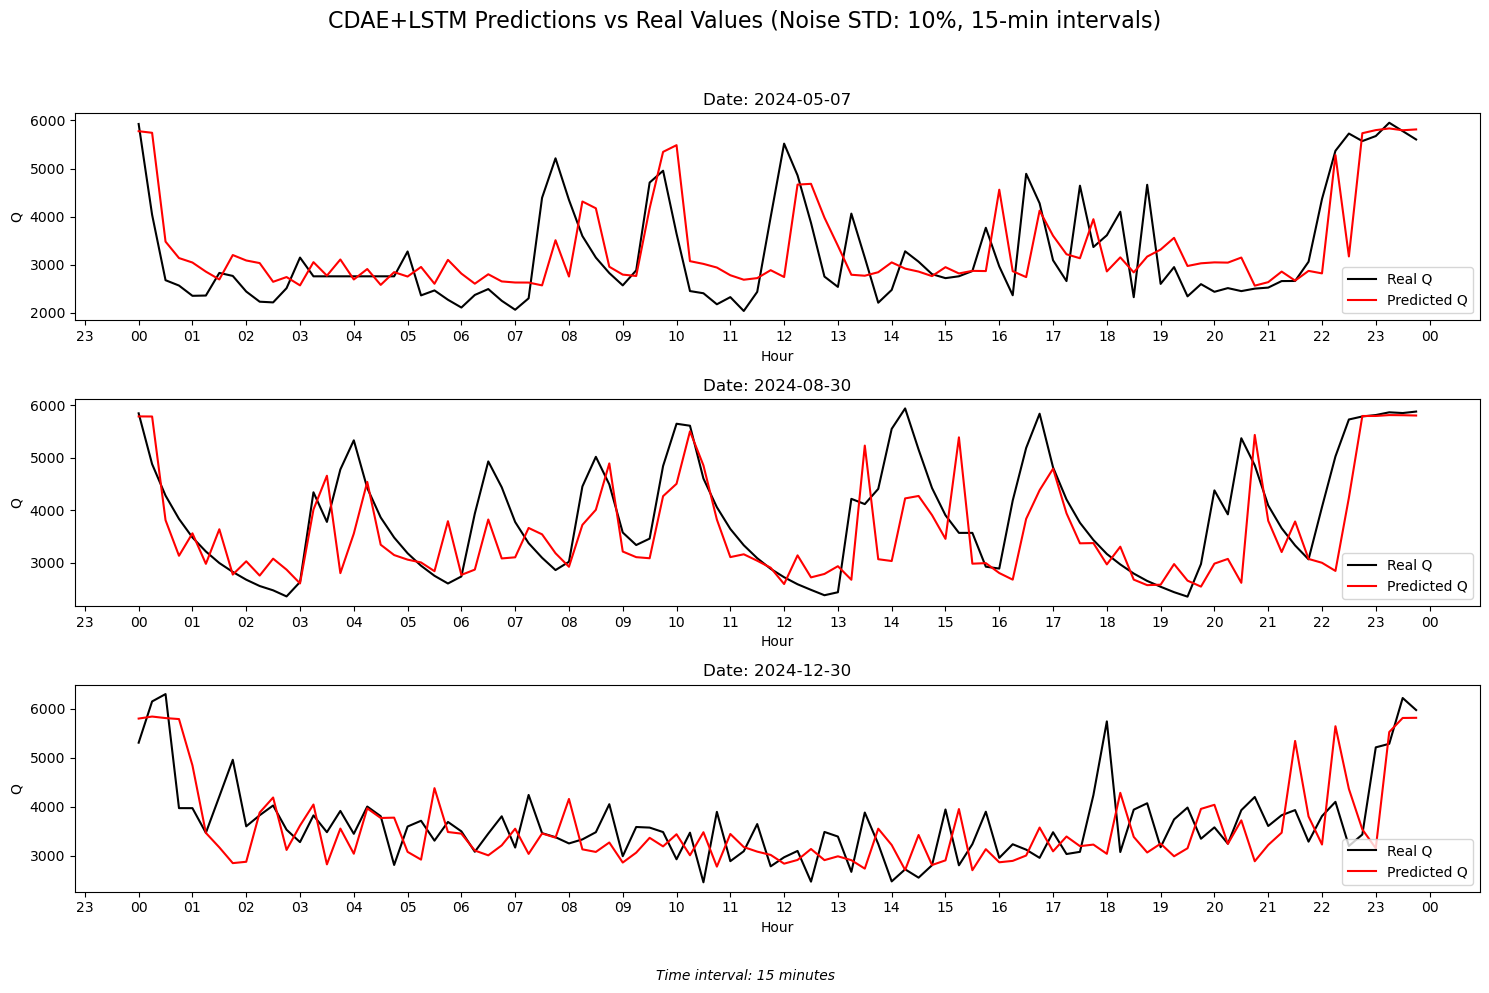

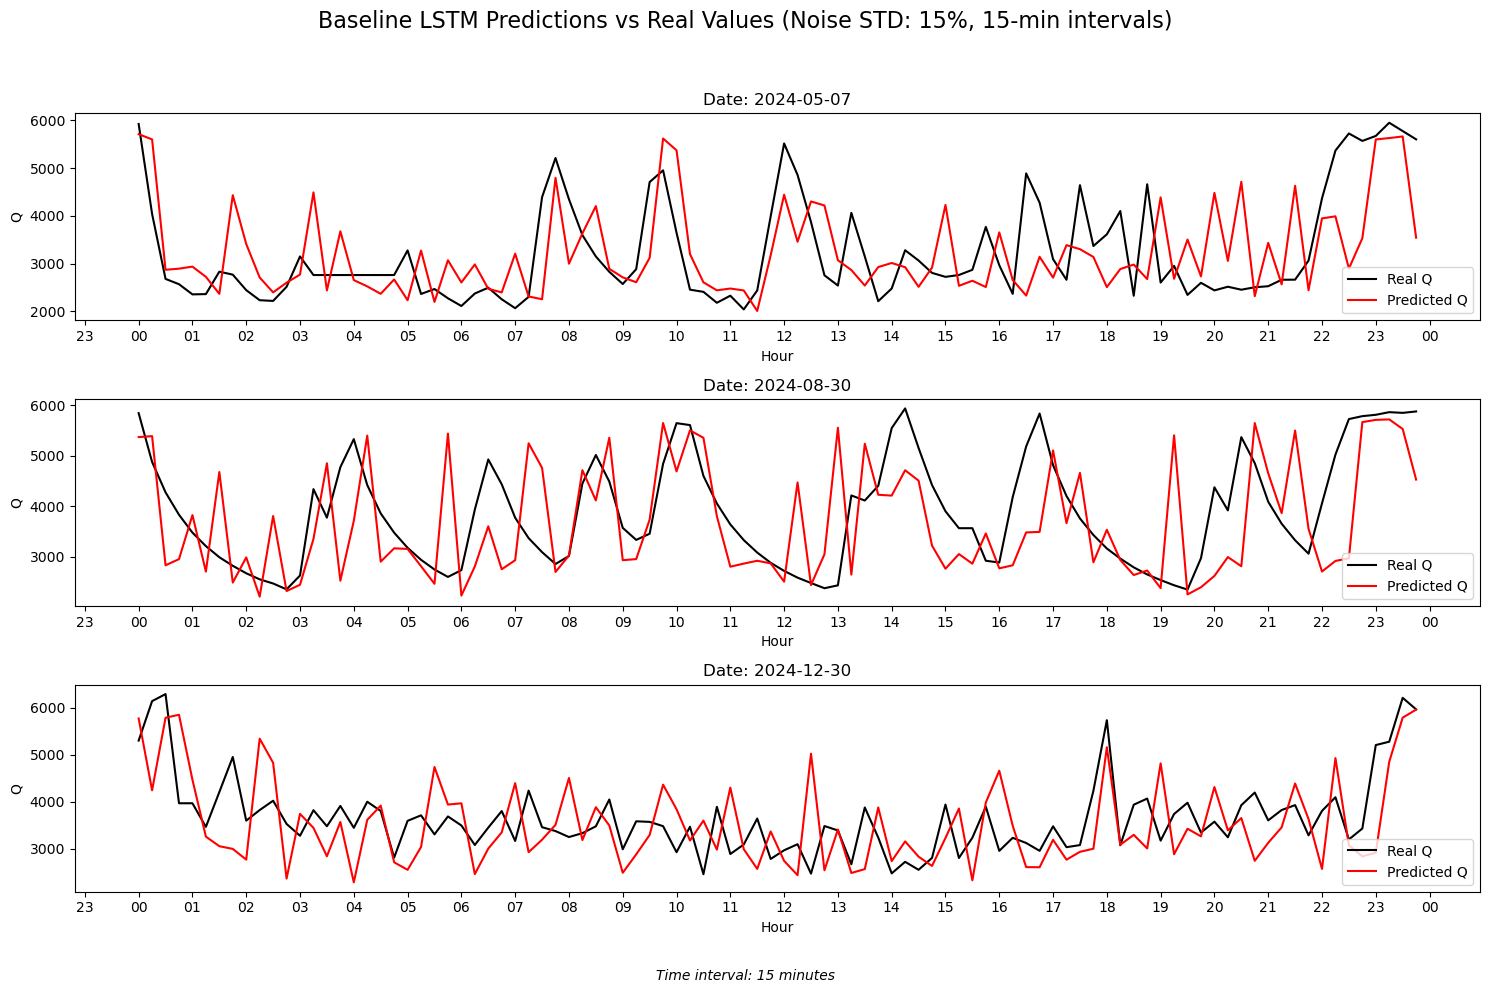

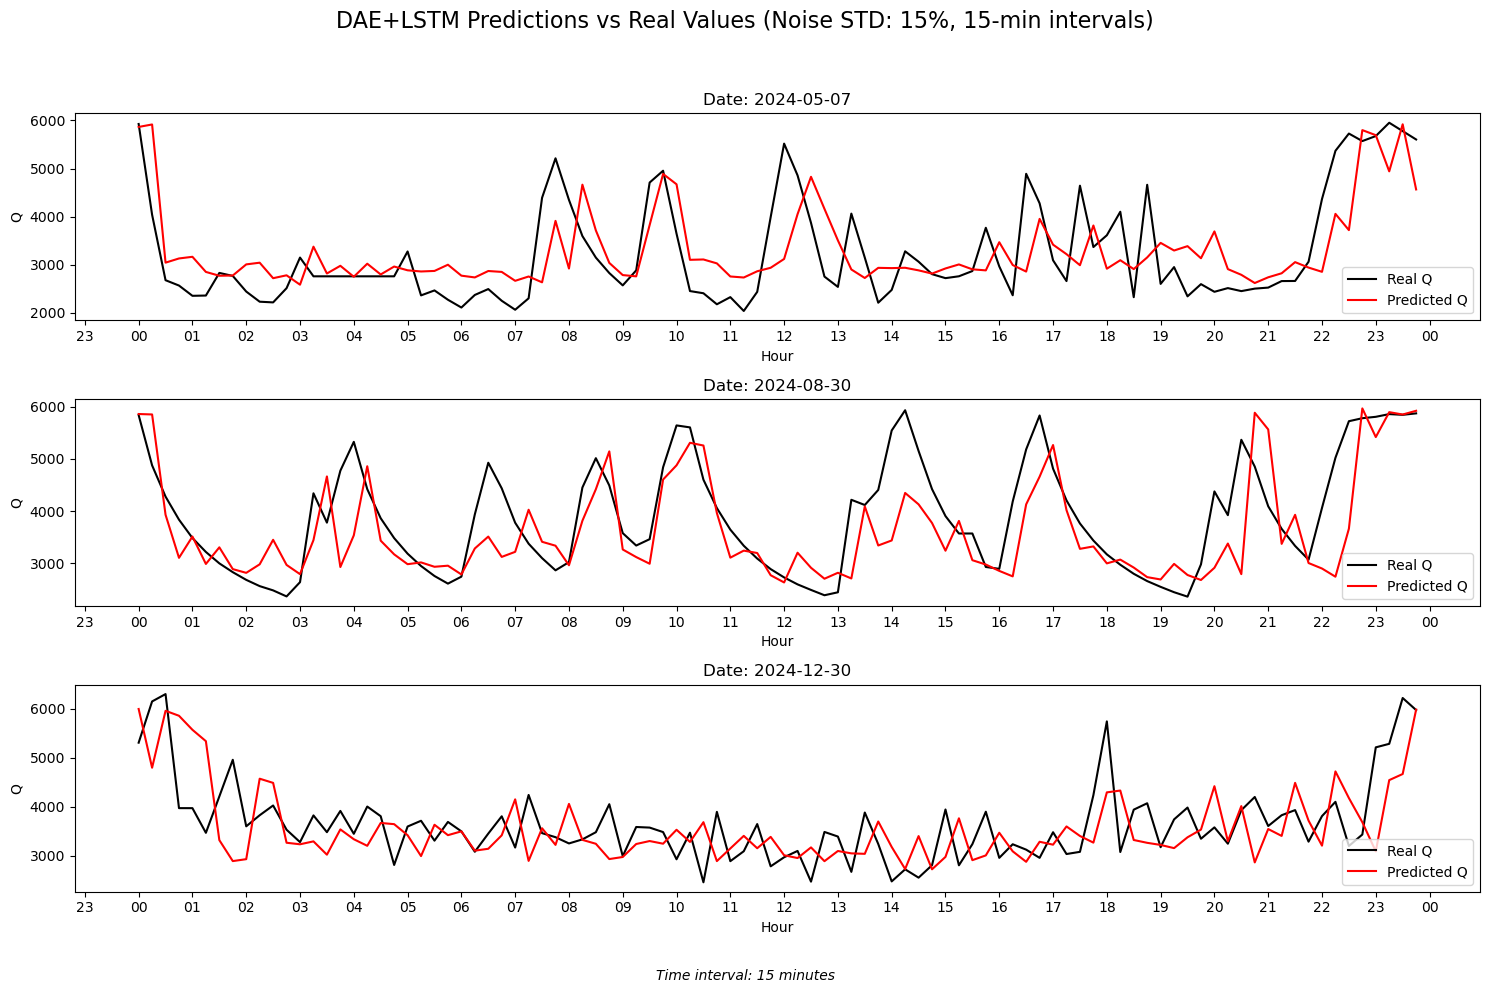

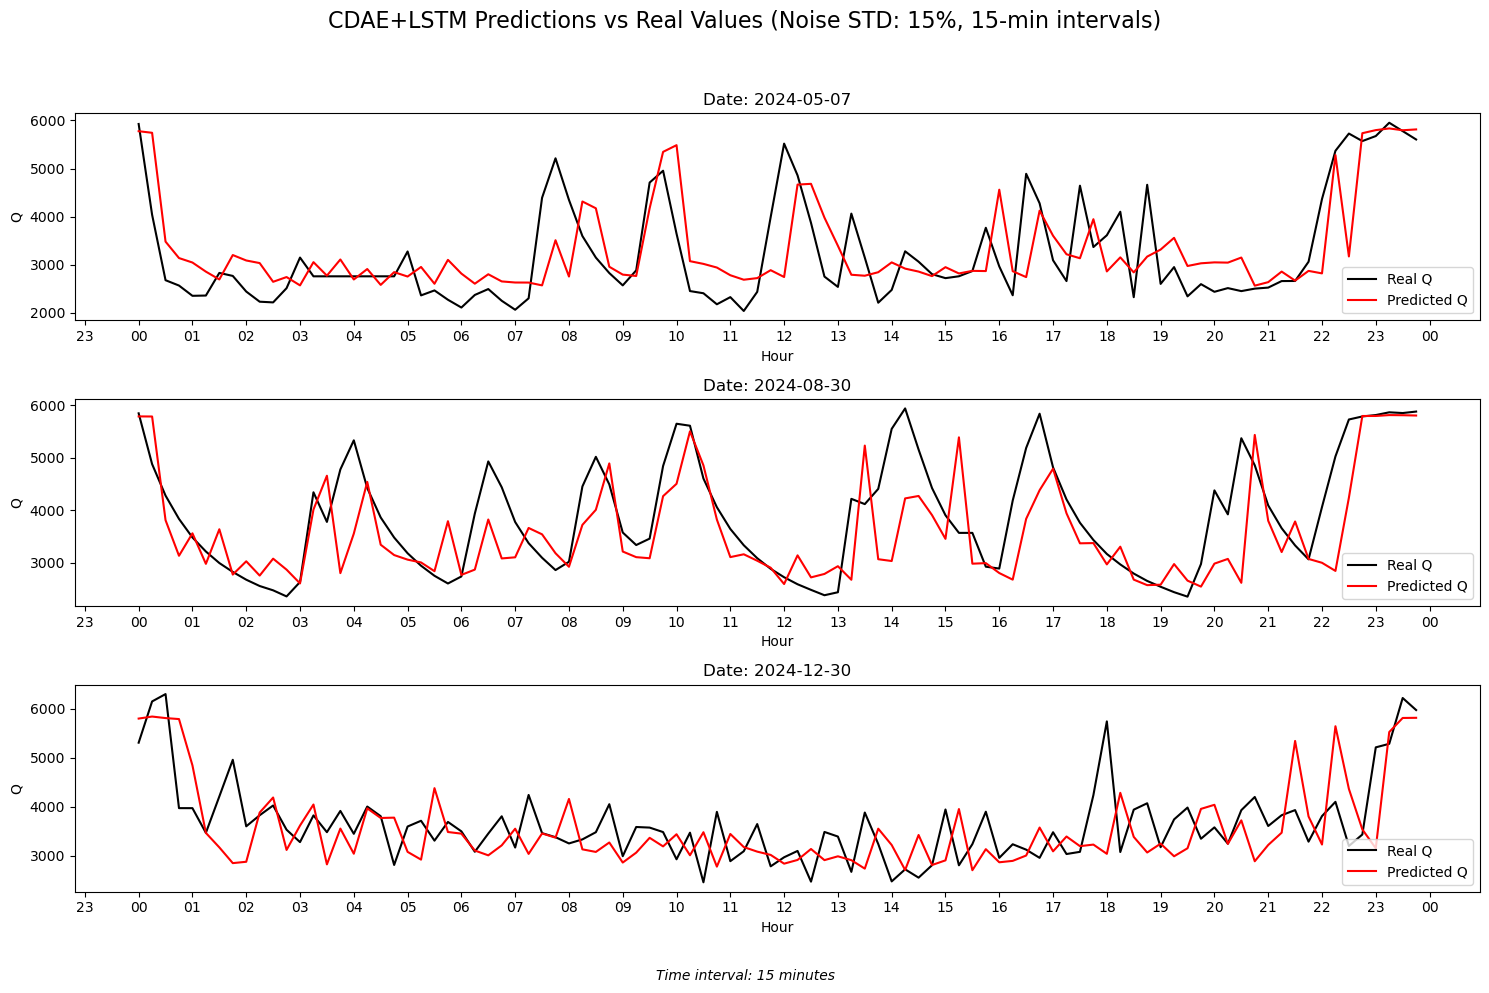

In [35]:
# =============================================================================
# 0. Define a Custom Layer: RandomGaussianNoise
# =============================================================================
class RandomGaussianNoise(tf.keras.layers.Layer):
    def __init__(self, min_std=0.0, max_std=0.15, **kwargs):
        super(RandomGaussianNoise, self).__init__(**kwargs)
        self.min_std = min_std
        self.max_std = max_std

    def call(self, inputs, training=None):
        if training:
            noise_std = tf.random.uniform([], minval=self.min_std, maxval=self.max_std)
            noise = tf.random.normal(tf.shape(inputs)) * noise_std
            return inputs + noise
        return inputs

# =============================================================================
# 1. Load and Basic Preprocessing of Heat-Load Data
# =============================================================================
df = pd.read_csv("/Users/aniaboutarene/Desktop/heat_load_data_office.csv")  # Adjust path as needed
Cp = 4182
df['Q'] = df['m'] * Cp * (df["Ts"] - df["Tr"]) / 3600

# Retain only timestamp and Q
df = df[['timestamp', 'Q']]
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)

# Resample to 15 minutes and fill missing values
df = df.resample('15T').mean()
df['Q'] = df['Q'].ffill()

# =============================================================================
# 2. Feature Engineering (Time-based Features Only)
# =============================================================================
df["hour"] = df.index.hour
df["dayofweek"] = df.index.dayofweek
df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)
df["dow_sin"]  = np.sin(2 * np.pi * df["dayofweek"] / 7)
df["dow_cos"]  = np.cos(2 * np.pi * df["dayofweek"] / 7)
df['weekend'] = df.index.dayofweek.isin([5,6]).astype(int)
austrian_holidays = holidays.Austria(years=df.index.year.unique())
df['holiday'] = df.index.isin(austrian_holidays).astype(int)

# =============================================================================
# 3. Select Features & Split Data by Date
# =============================================================================
features = df[["Q", "hour_sin", "hour_cos", "dow_sin", "dow_cos", "weekend", "holiday"]]

# Split the dataset on the date "2024-04-02"
test_df = features.loc[features.index >= '2024-04-02'].copy()
train_df = features.loc[features.index < '2024-04-02'].copy()

# =============================================================================
# 4. Further Split train_df into train_df and val_df
# =============================================================================
val_size = int(len(train_df) * 0.1)
val_df = train_df.iloc[-val_size:].copy()
train_df = train_df.iloc[:-val_size].copy()

# =============================================================================
# 5. Scaling and Sequence Creation
# =============================================================================
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_df)
val_scaled   = scaler.transform(val_df)
test_scaled  = scaler.transform(test_df)

def create_sequences(data, lookback, horizon, target_col=0):
    X, y = [], []
    for i in range(len(data) - lookback - horizon + 1):
        X_seq = data[i : i + lookback]
        y_seq = data[i + lookback : i + lookback + horizon, target_col]
        X.append(X_seq)
        y.append(y_seq)
    return np.array(X), np.array(y).reshape(-1, horizon, 1)

lookback = 8   # 2 hours lookback (8 time steps of 15 minutes each)
horizon  = 1   # Forecasting 15 minutes ahead

X_train, y_train = create_sequences(train_scaled, lookback, horizon)
X_val, y_val     = create_sequences(val_scaled, lookback, horizon)
X_test, y_test   = create_sequences(test_scaled, lookback, horizon)

# Since our modified model treats each sample as an image, add a channel dimension:
X_train = X_train[..., np.newaxis]   # now shape: (samples, lookback, num_features, 1)
X_val   = X_val[..., np.newaxis]
X_test  = X_test[..., np.newaxis]

# =============================================================================
# 6. Define Model Building Functions (Parameterizing num_features)
# =============================================================================
def build_baseline_model(hp, num_features):
    lstm_units = hp.Choice('lstm_units', values=[32, 64, 128], default=64)
    dropout_rate = hp.Choice('dropout_rate', values=[0.1, 0.2, 0.3], default=0.2)
    model = Sequential([
        LSTM(lstm_units, input_shape=(lookback, num_features), return_sequences=False),
        Dense(32, activation='linear'),
        Dropout(dropout_rate),
        RepeatVector(horizon),
        LSTM(64, return_sequences=True),
        TimeDistributed(Dense(1))
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mae', metrics=['mae'])
    return model

def build_dae_model(hp, num_features):
    inputs = Input(shape=(lookback, num_features))
    x = RandomGaussianNoise(min_std=0.0, max_std=0.15)(inputs)
    x = TimeDistributed(Dense(64, activation='elu'))(x)
    x = TimeDistributed(Dense(32, activation='elu'))(x)
    latent = LSTM(32, activation='tanh', return_sequences=False, name="latent_space")(x)
    x_dec = RepeatVector(lookback)(latent)
    x_dec = LSTM(64, activation='tanh', return_sequences=True)(x_dec)
    x_dec = TimeDistributed(Dense(32, activation='elu'))(x_dec)
    x_dec = TimeDistributed(Dense(64, activation='elu'))(x_dec)
    outputs = TimeDistributed(Dense(num_features, activation='linear'))(x_dec)
    dae = Model(inputs, outputs)
    dae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')
    
    # Build forecasting branch
    dae_encoder = Model(inputs, dae.get_layer("latent_space").output)
    forecast_dropout = hp.Choice('forecast_dropout', values=[0.1, 0.2, 0.3], default=0.2)
    latent_input = Input(shape=(32,))
    x_f = Dropout(forecast_dropout)(latent_input)
    x_f = RepeatVector(horizon)(x_f)
    x_f = LSTM(64, return_sequences=True)(x_f)
    forecast_output = TimeDistributed(Dense(1))(x_f)
    forecast_model = Model(latent_input, forecast_output)
    forecast_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mae', metrics=['mae'])
    
    outputs_forecast = forecast_model(dae_encoder(inputs))
    combined_model = Model(inputs, outputs_forecast)
    combined_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mae', metrics=['mae'])
    return combined_model

def build_conv_dae_model(hp, num_features):
    # Modified version: treat the data as an image
    # New input shape: (lookback, num_features, 1)
    inputs = Input(shape=(lookback, num_features, 1))
    x = RandomGaussianNoise(min_std=0.0, max_std=0.15)(inputs)
    
    # Encoder: use 2D Conv layers with a 3x3 kernel and ELU activation, followed by MaxPooling2D
    x = Conv2D(filters=5, kernel_size=(3, 3), strides=(1, 1), activation='elu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
    x = Conv2D(filters=25, kernel_size=(3, 3), strides=(1, 1), activation='elu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
    x = Conv2D(filters=125, kernel_size=(3, 3), strides=(1, 1), activation='elu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
    
    # Flatten the feature maps and build the latent representation
    x = Flatten()(x)
    latent = Dense(32, activation='linear', name='latent_space')(x)
    
    # Decoder: reverse encoder steps
    # Determine dimensions after three poolings (each pool reduces dimension by factor of 2)
    encoded_height = int(math.ceil(lookback / 2 / 2 / 2))
    encoded_width  = int(math.ceil(num_features / 2 / 2 / 2))
    flattened_dim = encoded_height * encoded_width * 125
    x_dec = Dense(flattened_dim, activation='elu')(latent)
    x_dec = Reshape((encoded_height, encoded_width, 125))(x_dec)
    
    x_dec = UpSampling2D(size=(2, 2))(x_dec)
    x_dec = Conv2D(filters=25, kernel_size=(3, 3), strides=(1, 1), activation='elu', padding='same')(x_dec)
    x_dec = UpSampling2D(size=(2, 2))(x_dec)
    x_dec = Conv2D(filters=5, kernel_size=(3, 3), strides=(1, 1), activation='elu', padding='same')(x_dec)
    x_dec = UpSampling2D(size=(2, 2))(x_dec)
    
    # Adjust output dimensions to match original (lookback, num_features)
    current_height = encoded_height * 2 * 2 * 2  # After three upsampling layers
    current_width  = encoded_width * 2 * 2 * 2
    if current_height > lookback or current_width > num_features:
        crop_height = current_height - lookback
        crop_width = current_width - num_features
        x_dec = Cropping2D(cropping=((0, crop_height), (0, crop_width)))(x_dec)
    elif current_height < lookback or current_width < num_features:
        pad_height = lookback - current_height
        pad_width = num_features - current_width
        x_dec = ZeroPadding2D(padding=((0, pad_height), (0, pad_width)))(x_dec)
    
    # Final reconstruction: output channels should be 1
    outputs_recon = Conv2D(filters=1, kernel_size=(3, 3), strides=(1, 1), activation='linear', padding='same')(x_dec)
    conv_autoencoder = Model(inputs, outputs_recon)
    conv_autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')
    
    # Forecasting branch
    conv_encoder = Model(inputs, conv_autoencoder.get_layer("latent_space").output)
    conv_forecast_dropout = hp.Choice('conv_forecast_dropout', values=[0.1, 0.2, 0.3], default=0.2)
    latent_input = Input(shape=(32,))
    x_f = Dropout(conv_forecast_dropout)(latent_input)
    x_f = RepeatVector(horizon)(x_f)
    x_f = LSTM(64, return_sequences=True)(x_f)
    forecast_output = TimeDistributed(Dense(1))(x_f)
    forecast_model = Model(latent_input, forecast_output)
    forecast_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mae', metrics=['mae'])
    
    outputs_forecast = forecast_model(conv_encoder(inputs))
    combined_model = Model(inputs, outputs_forecast)
    combined_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mae', metrics=['mae'])
    return combined_model

# =============================================================================
# 7. Hyperparameter Tuning for Each Model using Keras Tuner (5 Trials Each)
# =============================================================================
num_features = X_train.shape[2]  # Note: X_train is now 4D, but num_features remains unchanged

# Baseline LSTM (No Weather)
tuner_baseline = kt.RandomSearch(
    lambda hp: build_baseline_model(hp, num_features),
    objective='val_loss',
    max_trials=5,
    executions_per_trial=1,
    directory='tuning_dir_office_2g1_leak_new_o',
    project_name='baseline_model_no_weather'
)
print("Tuning Baseline LSTM (No Weather)...")
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)
tuner_baseline.search(X_train[..., 0], y_train, epochs=100, validation_data=(X_val[..., 0], y_val),
    callbacks=[early_stop])
best_baseline_model = tuner_baseline.get_best_models(num_models=1)[0]

# DAE+LSTM (No Weather)
tuner_dae = kt.RandomSearch(
    lambda hp: build_dae_model(hp, num_features),
    objective='val_loss',
    max_trials=5,
    executions_per_trial=1,
    directory='tuning_dir_office_2g1_leak_new',
    project_name='dae_model_no_weather'
)
print("Tuning DAE+LSTM (No Weather)...")
tuner_dae.search(X_train[..., 0], y_train, epochs=100, validation_data=(X_val[..., 0], y_val) ,
    callbacks=[early_stop])
best_dae_model = tuner_dae.get_best_models(num_models=1)[0]

# CDAE+LSTM (No Weather)
tuner_conv_dae = kt.RandomSearch(
    lambda hp: build_conv_dae_model(hp, num_features),
    objective='val_loss',
    max_trials=5,
    executions_per_trial=1,
    directory='tuning_dir_office_2g1_leak_new_2D',
    project_name='conv_dae_model_no_weather'
)
print("Tuning CDAE+LSTM (No Weather)...")
tuner_conv_dae.search(X_train, y_train, epochs=100, validation_data=(X_val, y_val),
    callbacks=[early_stop])
best_conv_dae_model = tuner_conv_dae.get_best_models(num_models=1)[0]

# =============================================================================
# 8. Evaluate Models 
# =============================================================================

# Define helper functions

def add_noise(data, noise_std=0.1):
    return data + np.random.normal(0, noise_std, data.shape)


def safe_inverse_transform(pred_scaled, scaler):
    dummy = np.zeros((pred_scaled.shape[0], scaler.min_.shape[0]))
    dummy[:, 0] = pred_scaled
    inv = scaler.inverse_transform(dummy)
    return inv[:, 0]


def mape(y_true, y_pred, eps=1e-8):
    return np.mean(np.abs((y_true - y_pred) / (y_true + eps))) * 100


def mae_fn(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

# Retrieve true Q values
true_Q_test = safe_inverse_transform(y_test.reshape(-1), scaler)

# Prepare storage for summary metrics
results = []  # list of dicts: noise, model, mape, mae, lb_stat, lb_p, arch_stat, arch_p, ad_stat, ad_crit

noise_levels = [0.05, 0.1, 0.15]
models = [
    ('Baseline LSTM',    best_baseline_model, lambda X: X[...,0]),
    ('DAE+LSTM',         best_dae_model,       lambda X: X[...,0]),
    ('CDAE+LSTM',        best_conv_dae_model,  lambda X: X)
]

for noise_std in noise_levels:
    Xn = add_noise(X_test, noise_std)
    for name, model, slicer in models:
        # Predictions and inverse transform
        X_input = slicer(Xn)
        preds = model.predict(X_input).reshape(-1)
        preds_inv = safe_inverse_transform(preds, scaler)
        resid = true_Q_test - preds_inv

        # Compute metrics
        current_mape = mape(true_Q_test, preds_inv)
        current_mae  = mae_fn(true_Q_test, preds_inv)

        # Autocorrelation test
        lb = acorr_ljungbox(resid, lags=[10], return_df=True)
        lb_stat, lb_p = lb.lb_stat.iloc[0], lb.lb_pvalue.iloc[0]

        # ARCH test
        arch_stat, arch_pvalue, _, _ = sm.stats.diagnostic.het_arch(resid)

        # Anderson-Darling
        ad = anderson(resid, dist='norm')
        ad_stat = ad.statistic
        ad_crit = dict(zip(ad.significance_level, ad.critical_values))

        # Store results
        results.append({
            'noise_pct': noise_std * 100,
            'model': name,
            'MAPE': current_mape,
            'MAE': current_mae,
            'LjungBox_chi2': lb_stat,
            'LjungBox_p': lb_p,
            'ARCH_LM': arch_stat,
            'ARCH_p': arch_pvalue,
            'AD_stat': ad_stat,
            'AD_crit_vals': ad_crit
        })

# Display summary
for res in results:
    print(f"Noise {res['noise_pct']:.0f}% - Model: {res['model']}")
    print(f" MAPE: {res['MAPE']:.2f}%, MAE: {res['MAE']:.2f}")
    print(f" Ljung-Box: chi2={res['LjungBox_chi2']:.2f}, p={res['LjungBox_p']:.3f}")
    print(f" ARCH: LM={res['ARCH_LM']:.2f}, p={res['ARCH_p']:.3f}")
    crit_str = ', '.join(f"{sl}%:{cv:.2f}" for sl, cv in res['AD_crit_vals'].items())
    print(f" Anderson-Darling: A2={res['AD_stat']:.3f}, crit={{{crit_str}}}\n")

# =============================================================================
# 9. Plot Real vs Predicted for Selected Dates for Each Noise Level and Model
# =============================================================================
for noise_std in [0.05, 0.10, 0.15]:
    # === Prepare / simulate predictions for the current noise level ===
    # These should be computed BEFORE plotting.
    # baseline_preds_inv, dae_preds_inv, conv_preds_inv must be redefined here
    # true_Q_test, test_df, lookback must also match the current noise level data

    # (Assume this part is already done above the plotting)

    pred_timestamps = test_df.index[lookback:]
    plot_dates = ['2024-05-07', '2024-08-30', '2024-12-30']
    model_predictions = {
        'Baseline LSTM': baseline_preds_inv,
        'DAE+LSTM'    : dae_preds_inv,
        'CDAE+LSTM'   : conv_preds_inv
    }
    colors = {'Real': 'black', 'Predicted': 'red'}
    
    noise_title = f"Noise STD: {noise_std*100:.0f}%"

    for model_name, preds_inv in model_predictions.items():
        fig, axs = plt.subplots(len(plot_dates), 1, figsize=(15, 10), sharex=False)

        if len(plot_dates) == 1:
            axs = [axs]

        fig.suptitle(f"{model_name} Predictions vs Real Values ({noise_title}, 15-min intervals)", fontsize=16)
        
        for subplot_idx, date_str in enumerate(plot_dates):
            current_date = pd.Timestamp(date_str, tz='UTC')
            mask = pred_timestamps.floor('D') == current_date
            
            if mask.sum() == 0:
                print(f"No data available for {date_str} in the predictions for {model_name} at noise STD {noise_std*100:.0f}%")
                continue
            
            day_timestamps = pred_timestamps[mask]
            real_values = true_Q_test[mask]
            model_values = preds_inv[mask]
            
            ax = axs[subplot_idx]
            ax.plot(day_timestamps, real_values, label='Real Q', color=colors['Real'])
            ax.plot(day_timestamps, model_values, label='Predicted Q', color=colors['Predicted'])
            ax.set_xlabel('Hour')
            ax.set_ylabel('Q')
            ax.set_title(f"Date: {date_str}")
            ax.legend(loc='lower right')


            # === Format the x-axis to show only hours (00, 01, ...) ===
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%H', tz=day_timestamps.tz))
            ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
            ax.tick_params(axis='x', rotation=0)

        fig.tight_layout(rect=[0, 0.04, 1, 0.95])
        fig.text(0.5, 0.01, "Time interval: 15 minutes", ha="center", fontsize=10, style='italic')
        plt.show()


In [37]:
# =============================================================================
# 0. Define a Custom Layer: RandomGaussianNoise
# =============================================================================
class RandomGaussianNoise(tf.keras.layers.Layer):
    def __init__(self, min_std=0.0, max_std=0.15, **kwargs):
        super(RandomGaussianNoise, self).__init__(**kwargs)
        self.min_std = min_std
        self.max_std = max_std

    def call(self, inputs, training=None):
        if training:
            noise_std = tf.random.uniform([], minval=self.min_std, maxval=self.max_std)
            noise = tf.random.normal(tf.shape(inputs)) * noise_std
            return inputs + noise
        return inputs

# =============================================================================
# 1. Load and Basic Preprocessing of Heat-Load Data
# =============================================================================
df = pd.read_csv("/Users/aniaboutarene/Desktop/heat_load_data_hotel.csv")  # Adjust path as needed
Cp = 4182
df['Q'] = df['m'] * Cp * (df["Ts"] - df["Tr"]) / 3600

# Retain only timestamp and Q
df = df[['timestamp', 'Q']]
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)

# Resample to 15 minutes and fill missing values
df = df.resample('15T').mean()
df['Q'] = df['Q'].ffill()

# =============================================================================
# 2. Feature Engineering (Time-based Features Only)
# =============================================================================
df["hour"] = df.index.hour
df["dayofweek"] = df.index.dayofweek
df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)
df["dow_sin"]  = np.sin(2 * np.pi * df["dayofweek"] / 7)
df["dow_cos"]  = np.cos(2 * np.pi * df["dayofweek"] / 7)
df['weekend'] = df.index.dayofweek.isin([5,6]).astype(int)
austrian_holidays = holidays.Austria(years=df.index.year.unique())
df['holiday'] = df.index.isin(austrian_holidays).astype(int)

# =============================================================================
# 3. Select Features & Split Data by Date
# =============================================================================
features = df[["Q", "hour_sin", "hour_cos", "dow_sin", "dow_cos", "weekend", "holiday"]]

# Split the dataset on the date "2024-04-02"
test_df = features.loc[features.index >= '2024-04-02'].copy()
train_df = features.loc[features.index < '2024-04-02'].copy()

# =============================================================================
# 4. Further Split train_df into train_df and val_df
# =============================================================================
val_size = int(len(train_df) * 0.1)
val_df = train_df.iloc[-val_size:].copy()
train_df = train_df.iloc[:-val_size].copy()

# =============================================================================
# 5. Scaling and Sequence Creation
# =============================================================================
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_df)
val_scaled   = scaler.transform(val_df)
test_scaled  = scaler.transform(test_df)

def create_sequences(data, lookback, horizon, target_col=0):
    X, y = [], []
    for i in range(len(data) - lookback - horizon + 1):
        X_seq = data[i : i + lookback]
        y_seq = data[i + lookback : i + lookback + horizon, target_col]
        X.append(X_seq)
        y.append(y_seq)
    return np.array(X), np.array(y).reshape(-1, horizon, 1)

lookback = 8   # 2 hours lookback (8 time steps of 15 minutes each)
horizon  = 1   # Forecasting 15 minutes ahead

X_train, y_train = create_sequences(train_scaled, lookback, horizon)
X_val, y_val     = create_sequences(val_scaled, lookback, horizon)
X_test, y_test   = create_sequences(test_scaled, lookback, horizon)

# Since our modified model treats each sample as an image, add a channel dimension:
X_train = X_train[..., np.newaxis]   # now shape: (samples, lookback, num_features, 1)
X_val   = X_val[..., np.newaxis]
X_test  = X_test[..., np.newaxis]

# =============================================================================
# 6. Define Model Building Functions (Parameterizing num_features)
# =============================================================================
def build_baseline_model(hp, num_features):
    lstm_units = hp.Choice('lstm_units', values=[32, 64, 128], default=64)
    dropout_rate = hp.Choice('dropout_rate', values=[0.1, 0.2, 0.3], default=0.2)
    model = Sequential([
        LSTM(lstm_units, input_shape=(lookback, num_features), return_sequences=False),
        Dense(32, activation='linear'),
        Dropout(dropout_rate),
        RepeatVector(horizon),
        LSTM(64, return_sequences=True),
        TimeDistributed(Dense(1))
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mae', metrics=['mae'])
    return model

def build_dae_model(hp, num_features):
    inputs = Input(shape=(lookback, num_features))
    x = RandomGaussianNoise(min_std=0.0, max_std=0.15)(inputs)
    x = TimeDistributed(Dense(64, activation='elu'))(x)
    x = TimeDistributed(Dense(32, activation='elu'))(x)
    latent = LSTM(32, activation='tanh', return_sequences=False, name="latent_space")(x)
    x_dec = RepeatVector(lookback)(latent)
    x_dec = LSTM(64, activation='tanh', return_sequences=True)(x_dec)
    x_dec = TimeDistributed(Dense(32, activation='elu'))(x_dec)
    x_dec = TimeDistributed(Dense(64, activation='elu'))(x_dec)
    outputs = TimeDistributed(Dense(num_features, activation='linear'))(x_dec)
    dae = Model(inputs, outputs)
    dae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')
    
    # Build forecasting branch
    dae_encoder = Model(inputs, dae.get_layer("latent_space").output)
    forecast_dropout = hp.Choice('forecast_dropout', values=[0.1, 0.2, 0.3], default=0.2)
    latent_input = Input(shape=(32,))
    x_f = Dropout(forecast_dropout)(latent_input)
    x_f = RepeatVector(horizon)(x_f)
    x_f = LSTM(64, return_sequences=True)(x_f)
    forecast_output = TimeDistributed(Dense(1))(x_f)
    forecast_model = Model(latent_input, forecast_output)
    forecast_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mae', metrics=['mae'])
    
    outputs_forecast = forecast_model(dae_encoder(inputs))
    combined_model = Model(inputs, outputs_forecast)
    combined_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mae', metrics=['mae'])
    return combined_model

def build_conv_dae_model(hp, num_features):
    # Modified version: treat the data as an image
    # New input shape: (lookback, num_features, 1)
    inputs = Input(shape=(lookback, num_features, 1))
    x = RandomGaussianNoise(min_std=0.0, max_std=0.15)(inputs)
    
    # Encoder: use 2D Conv layers with a 3x3 kernel and ELU activation, followed by MaxPooling2D
    x = Conv2D(filters=5, kernel_size=(3, 3), strides=(1, 1), activation='elu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
    x = Conv2D(filters=25, kernel_size=(3, 3), strides=(1, 1), activation='elu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
    x = Conv2D(filters=125, kernel_size=(3, 3), strides=(1, 1), activation='elu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
    
    # Flatten the feature maps and build the latent representation
    x = Flatten()(x)
    latent = Dense(32, activation='linear', name='latent_space')(x)
    
    # Decoder: reverse encoder steps
    # Determine dimensions after three poolings (each pool reduces dimension by factor of 2)
    encoded_height = int(math.ceil(lookback / 2 / 2 / 2))
    encoded_width  = int(math.ceil(num_features / 2 / 2 / 2))
    flattened_dim = encoded_height * encoded_width * 125
    x_dec = Dense(flattened_dim, activation='elu')(latent)
    x_dec = Reshape((encoded_height, encoded_width, 125))(x_dec)
    
    x_dec = UpSampling2D(size=(2, 2))(x_dec)
    x_dec = Conv2D(filters=25, kernel_size=(3, 3), strides=(1, 1), activation='elu', padding='same')(x_dec)
    x_dec = UpSampling2D(size=(2, 2))(x_dec)
    x_dec = Conv2D(filters=5, kernel_size=(3, 3), strides=(1, 1), activation='elu', padding='same')(x_dec)
    x_dec = UpSampling2D(size=(2, 2))(x_dec)
    
    # Adjust output dimensions to match original (lookback, num_features)
    current_height = encoded_height * 2 * 2 * 2  # After three upsampling layers
    current_width  = encoded_width * 2 * 2 * 2
    if current_height > lookback or current_width > num_features:
        crop_height = current_height - lookback
        crop_width = current_width - num_features
        x_dec = Cropping2D(cropping=((0, crop_height), (0, crop_width)))(x_dec)
    elif current_height < lookback or current_width < num_features:
        pad_height = lookback - current_height
        pad_width = num_features - current_width
        x_dec = ZeroPadding2D(padding=((0, pad_height), (0, pad_width)))(x_dec)
    
    # Final reconstruction: output channels should be 1
    outputs_recon = Conv2D(filters=1, kernel_size=(3, 3), strides=(1, 1), activation='linear', padding='same')(x_dec)
    conv_autoencoder = Model(inputs, outputs_recon)
    conv_autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')
    
    # Forecasting branch
    conv_encoder = Model(inputs, conv_autoencoder.get_layer("latent_space").output)
    conv_forecast_dropout = hp.Choice('conv_forecast_dropout', values=[0.1, 0.2, 0.3], default=0.2)
    latent_input = Input(shape=(32,))
    x_f = Dropout(conv_forecast_dropout)(latent_input)
    x_f = RepeatVector(horizon)(x_f)
    x_f = LSTM(64, return_sequences=True)(x_f)
    forecast_output = TimeDistributed(Dense(1))(x_f)
    forecast_model = Model(latent_input, forecast_output)
    forecast_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mae', metrics=['mae'])
    
    outputs_forecast = forecast_model(conv_encoder(inputs))
    combined_model = Model(inputs, outputs_forecast)
    combined_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mae', metrics=['mae'])
    return combined_model

# =============================================================================
# 7. Hyperparameter Tuning for Each Model using Keras Tuner (5 Trials Each)
# =============================================================================
num_features = X_train.shape[2]  # Note: X_train is now 4D, but num_features remains unchanged
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)
# Baseline LSTM (No Weather)
tuner_baseline = kt.RandomSearch(
    lambda hp: build_baseline_model(hp, num_features),
    objective='val_loss',
    max_trials=5,
    executions_per_trial=1,
    directory='tuning_dir_hotel_2g1_leak_new_o',
    project_name='baseline_model_no_weather'
)
print("Tuning Baseline LSTM (No Weather)...")
tuner_baseline.search(X_train[..., 0], y_train, epochs=100, validation_data=(X_val[..., 0], y_val),
    callbacks=[early_stop])
best_baseline_model = tuner_baseline.get_best_models(num_models=1)[0]

# DAE+LSTM (No Weather)
tuner_dae = kt.RandomSearch(
    lambda hp: build_dae_model(hp, num_features),
    objective='val_loss',
    max_trials=5,
    executions_per_trial=1,
    directory='tuning_dir_hotel_2g1_leak_new_o',
    project_name='dae_model_no_weather'
)
print("Tuning DAE+LSTM (No Weather)...")
tuner_dae.search(X_train[..., 0], y_train, epochs=100, validation_data=(X_val[..., 0], y_val),
    callbacks=[early_stop])
best_dae_model = tuner_dae.get_best_models(num_models=1)[0]

# CDAE+LSTM (No Weather)
tuner_conv_dae = kt.RandomSearch(
    lambda hp: build_conv_dae_model(hp, num_features),
    objective='val_loss',
    max_trials=5,
    executions_per_trial=1,
    directory='tuning_dir_hotel_2g1_leak_new_o',
    project_name='conv_dae_model_no_weather'
)
print("Tuning CDAE+LSTM (No Weather)...")
tuner_conv_dae.search(X_train, y_train, epochs=100, validation_data=(X_val, y_val),
    callbacks=[early_stop])
best_conv_dae_model = tuner_conv_dae.get_best_models(num_models=1)[0]
# =============================================================================
# 8. Evaluate Models 
# =============================================================================

# Define helper functions

def add_noise(data, noise_std=0.1):
    return data + np.random.normal(0, noise_std, data.shape)


def safe_inverse_transform(pred_scaled, scaler):
    dummy = np.zeros((pred_scaled.shape[0], scaler.min_.shape[0]))
    dummy[:, 0] = pred_scaled
    inv = scaler.inverse_transform(dummy)
    return inv[:, 0]


def mape(y_true, y_pred, eps=1e-8):
    return np.mean(np.abs((y_true - y_pred) / (y_true + eps))) * 100


def mae_fn(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

# Retrieve true Q values
true_Q_test = safe_inverse_transform(y_test.reshape(-1), scaler)

# Prepare storage for summary metrics
results = []  # list of dicts: noise, model, mape, mae, lb_stat, lb_p, arch_stat, arch_p, ad_stat, ad_crit

noise_levels = [0.05, 0.1, 0.15]
models = [
    ('Baseline LSTM',    best_baseline_model, lambda X: X[...,0]),
    ('DAE+LSTM',         best_dae_model,       lambda X: X[...,0]),
    ('CDAE+LSTM',        best_conv_dae_model,  lambda X: X)
]

for noise_std in noise_levels:
    Xn = add_noise(X_test, noise_std)
    for name, model, slicer in models:
        # Predictions and inverse transform
        X_input = slicer(Xn)
        preds = model.predict(X_input).reshape(-1)
        preds_inv = safe_inverse_transform(preds, scaler)
        resid = true_Q_test - preds_inv

        # Compute metrics
        current_mape = mape(true_Q_test, preds_inv)
        current_mae  = mae_fn(true_Q_test, preds_inv)

        # Autocorrelation test
        lb = acorr_ljungbox(resid, lags=[10], return_df=True)
        lb_stat, lb_p = lb.lb_stat.iloc[0], lb.lb_pvalue.iloc[0]

        # ARCH test
        arch_stat, arch_pvalue, _, _ = sm.stats.diagnostic.het_arch(resid)

        # Anderson-Darling
        ad = anderson(resid, dist='norm')
        ad_stat = ad.statistic
        ad_crit = dict(zip(ad.significance_level, ad.critical_values))

        # Store results
        results.append({
            'noise_pct': noise_std * 100,
            'model': name,
            'MAPE': current_mape,
            'MAE': current_mae,
            'LjungBox_chi2': lb_stat,
            'LjungBox_p': lb_p,
            'ARCH_LM': arch_stat,
            'ARCH_p': arch_pvalue,
            'AD_stat': ad_stat,
            'AD_crit_vals': ad_crit
        })

# Display summary
for res in results:
    print(f"Noise {res['noise_pct']:.0f}% - Model: {res['model']}")
    print(f" MAPE: {res['MAPE']:.2f}%, MAE: {res['MAE']:.2f}")
    print(f" Ljung-Box: chi2={res['LjungBox_chi2']:.2f}, p={res['LjungBox_p']:.3f}")
    print(f" ARCH: LM={res['ARCH_LM']:.2f}, p={res['ARCH_p']:.3f}")
    crit_str = ', '.join(f"{sl}%:{cv:.2f}" for sl, cv in res['AD_crit_vals'].items())
    print(f" Anderson-Darling: A2={res['AD_stat']:.3f}, crit={{{crit_str}}}\n")



Reloading Tuner from tuning_dir_hotel_2g1_leak_new_o/baseline_model_no_weather/tuner0.json
Tuning Baseline LSTM (No Weather)...
Reloading Tuner from tuning_dir_hotel_2g1_leak_new_o/dae_model_no_weather/tuner0.json
Tuning DAE+LSTM (No Weather)...
Reloading Tuner from tuning_dir_hotel_2g1_leak_new_o/conv_dae_model_no_weather/tuner0.json
Tuning CDAE+LSTM (No Weather)...
822/822 ━━━━━━━━━━━━━━━━━━━━ 1s 618us/step
822/822 ━━━━━━━━━━━━━━━━━━━━ 1s 745us/step
822/822 ━━━━━━━━━━━━━━━━━━━━ 1s 680us/step
822/822 ━━━━━━━━━━━━━━━━━━━━ 1s 681us/step
822/822 ━━━━━━━━━━━━━━━━━━━━ 1s 719us/step
822/822 ━━━━━━━━━━━━━━━━━━━━ 1s 681us/step
822/822 ━━━━━━━━━━━━━━━━━━━━ 1s 696us/step
822/822 ━━━━━━━━━━━━━━━━━━━━ 1s 756us/step
822/822 ━━━━━━━━━━━━━━━━━━━━ 1s 716us/step
Noise 5% - Model: Baseline LSTM
 MAPE: 8.74%, MAE: 315.40
 Ljung-Box: chi2=180.16, p=0.000
 ARCH: LM=1448.05, p=0.000
 Anderson-Darling: A2=155.161, crit={15.0%:0.58, 10.0%:0.66, 5.0%:0.79, 2.5%:0.92, 1.0%:1.09}

Noise 5% - Model: DAE+LSTM
 MA

In [49]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.signal import periodogram

def analyze_periodicity(path, name):
    # Load data
    df = pd.read_csv(path, parse_dates=['timestamp'], index_col='timestamp')
    Cp = 4182
    # Compute heat load Q in kJ
    df['Q'] = df['m'] * Cp * (df['Ts'] - df['Tr']) / 3600
    # Resample to 15-minute intervals
    df = df[['Q']].resample('15T').mean().ffill()

    # 1. Autocorrelation
    acf_vals = acf(df['Q'], nlags=168, fft=True)
    acf_daily   = acf_vals[24]
    acf_weekly  = acf_vals[168]

    # 2. Periodogram
    freq, psd = periodogram(df['Q'], fs=4)  # 4 samples/hour
    idx_daily  = np.argmin(np.abs(freq - 1/24))
    idx_weekly = np.argmin(np.abs(freq - 1/168))
    psd_daily  = psd[idx_daily]
    psd_weekly = psd[idx_weekly]

    # 3a. Daily seasonal strength (period = 24h → 24*4 = 96 samples)
    decomp_daily = seasonal_decompose(df['Q'], period=24*4, model='additive', extrapolate_trend='freq')
    resid_d = np.var(decomp_daily.resid.dropna())
    seas_d  = np.var(decomp_daily.seasonal)
    seasonal_strength_daily = max(0, 1 - resid_d / (resid_d + seas_d))

    # 3b. Weekly seasonal strength (period = 168h → 168*4 = 672 samples)
    decomp_weekly = seasonal_decompose(df['Q'], period=168*4, model='additive', extrapolate_trend='freq')
    resid_w = np.var(decomp_weekly.resid.dropna())
    seas_w  = np.var(decomp_weekly.seasonal)
    seasonal_strength_weekly = max(0, 1 - resid_w / (resid_w + seas_w))

    # Compile results
    results = {
        'Dataset': name,
        'ACF@24h': acf_daily,
        'ACF@168h': acf_weekly,
        'PSD@1/24h': psd_daily,
        'PSD@1/168h': psd_weekly,
        'SeasonalStrength@24h': seasonal_strength_daily,
        'SeasonalStrength@168h': seasonal_strength_weekly
    }
    return results

# Paths to CSV files
paths = {
    'Public-Commercial': '/Users/aniaboutarene/Desktop/heat_load_data_pubcom.csv',
    'Office': '/Users/aniaboutarene/Desktop/heat_load_data_office.csv',
    'Hotel': '/Users/aniaboutarene/Desktop/heat_load_data_hotel.csv'
}

# Analyze and output results
results_list = []
for name, path in paths.items():
    try:
        res = analyze_periodicity(path, name)
        results_list.append(res)
    except FileNotFoundError:
        print(f"File not found: {path}. Please adjust the path.")

if results_list:
    results_df = pd.DataFrame(results_list).set_index('Dataset')
    # Print summary table
    print("Periodicity Metrics:\n", results_df)


Periodicity Metrics:
                     ACF@24h  ACF@168h     PSD@1/24h    PSD@1/168h  \
Dataset                                                             
Public-Commercial  0.941009  0.807343  7.636272e+06  8.752125e+05   
Office             0.394518  0.272421  7.297273e+07  8.132314e+06   
Hotel              0.721336  0.566469  1.620863e+07  2.084882e+06   

                   SeasonalStrength@24h  SeasonalStrength@168h  
Dataset                                                         
Public-Commercial              0.046891               0.022295  
Office                         0.195070               0.170449  
Hotel                          0.025524               0.030465  
